In [42]:
import json
import os
import uuid
import time
from dotenv import load_dotenv
import chromadb
from chromadb import EmbeddingFunction, Documents, Embeddings
import google.generativeai as genai


In [43]:


# --- Загрузка API ключа ---
load_dotenv()
genai.configure(
    api_key=os.getenv("GEMENI_API_KEY")
)
# --- Настройки ChromaDB ---
CHROMA_PATH = "./chroma_db"
COLLECTION_NAME = "tag_docs"

# --- Функция эмбендинга ---
class GeminiEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        model = 'models/embedding-001'
        title = "tags"
        return genai.embed_content(
            model=model,
            content=input,
            task_type="retrieval_document",
            title=title
        )["embedding"]

# --- Работа с ChromaDB ---
def get_chroma_db():
    chroma_client = chromadb.PersistentClient(path=CHROMA_PATH)
    return chroma_client.get_or_create_collection(name=COLLECTION_NAME, embedding_function=GeminiEmbeddingFunction())

def relevant_docs(query, db, n_results=2):
    passages = db.query(query_texts=[query], n_results=n_results)['documents'][0]
    return passages


In [44]:
db= get_chroma_db()
db.count()

C:\Users\liali\AppData\Local\Temp\ipykernel_3416\3107007383.py:25: DeprecationWarning: The class GeminiEmbeddingFunction does not implement __init__. This will be required in a future version.
  return chroma_client.get_or_create_collection(name=COLLECTION_NAME, embedding_function=GeminiEmbeddingFunction())


36

In [45]:
type(db)

chromadb.api.models.Collection.Collection

In [46]:
question= "red eyes"
passages= relevant_docs(question, db, 2)

print(''.join(passages))


Tag: two-tone eyes
Description: Eyes that have two distinct colors within the same eye socket, as long as the colors are not similar enough to be described as gradient eyes.
Do not use this tag.
Instruction: Delete this tag if it's in promt. Examples:
red eyes, blue eyes, two-tone eyes -> red-blue eyes
grey eyes, white eyes, two-tone eyes -> grey-white eyes
Category: eyes
Tag: red eyes
Description: A character with red colored eyes.
Due to the subjective nature of color judgment and other factors (such as the lighting on the characters), there is an overlap between this tag and the orange eyes and brown eyes tags.
Instruction: red eyes can be merged with:

Other eye colors
Merge with other eye color tags such as blue eyes, black eyes, white eyes, yellow eyes to form compound tags like red-blue eyes, red-white eyes, red-black gradient eyes
Do not merge with multicolored eyes or rainbow eyes

Examples:
red eyes, blue eyes -> red-blue eyes
red eyes, black eyes, gradient eyes -> red-black 

In [47]:
frequently_missed_eye_tags = {
"ringed eyes", 
"pupil color",
"black pupils",
"aqua pupils",
"blue pupils",
"brown pupils",
"green pupils",
"grey pupils",
"orange pupils",
"pink pupils",
"purple pupils",
"red pupils",
"white pupils",
"yellow pupils",
}

In [48]:
 

import mimetypes

 

def find_often_mising_tags_promt(image_path: str, existing_tags: list, often_missed_tags: list, db: chromadb.api.models.Collection.Collection):
    import mimetypes

    existing_tag_set = set(existing_tags)
    tags_to_check = [tag for tag in often_missed_tags if tag not in existing_tag_set]

    if not tags_to_check:
        return None, []

    number_documents_to_get = min(len(tags_to_check), db.count())

    # Получаем исходные документы
    raw_docs = relevant_docs(', '.join(tags_to_check), db, number_documents_to_get)

    # Фильтруем: оставляем только Tag и Description
    def extract_tag_and_description(text):
        tag, description = None, None
        for line in text.splitlines():
            if line.startswith("Tag:"):
                tag = line.replace("Tag:", "").strip()
            elif line.startswith("Description:"):
                description = line.replace("Description:", "").strip()
            elif line.startswith("Instruction:") or line.startswith("Category:"):
                break  # Прекращаем на ненужных секциях
            elif description is not None:
                description += '\n' + line  # продолжаем описание
        return f"Tag: {tag}\nDescription: {description}" if tag and description else ""

    documents_for_often_missing_tags = "\n\n".join(
        extract_tag_and_description(doc) for doc in raw_docs
    )

    prompt = f"""
You are a visual tag detection assistant. Your task is to analyze the image and detect which of the following tags are clearly visible.

You are also provided with documentation for these tags. Use it to understand their meaning and appearance more precisely before making a decision.

DOCUMENTATION FOR TAGS:
{documents_for_often_missing_tags}

CANDIDATE TAGS TO CHECK:
{', '.join(tags_to_check)}

IMPORTANT RULES:
- ONLY return tags that are clearly visible in the image.
- DO NOT guess, hallucinate, or add tags that you are unsure about.
- Use the documentation to understand exactly how each tag should look.
- If multiple tags apply, list them comma-separated.
- If none of the candidate tags are clearly visible, return an empty string.

Return format: comma-separated list of visible tags only.
""".strip()

    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as f:
        image_bytes = f.read()

    image_part = {
        "mime_type": mime_type,
        "data": image_bytes
    }

    return [image_part, prompt]



import mimetypes

def make_merging_prompt(image_path: str, existing_tags: list, db: chromadb.api.models.Collection.Collection):
    import mimetypes

    # Безопасная проверка
    if not existing_tags or not isinstance(existing_tags, list):
        raise ValueError("existing_tags must be a non-empty list")

    num_to_retrieve = min(len(existing_tags), db.count())
    query_text = ', '.join(existing_tags)
    relevant_documents = relevant_docs(query_text, db, num_to_retrieve)

    if isinstance(relevant_documents[0], dict):
        context = '\n'.join(doc.get("content", "") for doc in relevant_documents)
    else:
        context = '\n'.join(relevant_documents)

    context = context.replace("'", "").replace('"', '')

    prompt = f"""
You are a tag merging assistant. Your task is to combine the input tags into a clean and meaningful merged tag set, following the context rules below. You may use the image if needed.

CONTEXT RULES:
{context}

INPUT TAGS:
{', '.join(existing_tags)}

IMPORTANT RULES:
- Only merge according to the context instructions.
- Do NOT remove or change tags unless explicitly specified in the context.
- Your response MUST be a comma-separated list of tags only.
- Do NOT explain or format your answer. Just return the merged tag list as plain text.

EXAMPLE FORMAT:
tag1, tag2, tag3

Merged tag list:
""".strip()

    # Загрузка изображения
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as f:
        image_bytes = f.read()

    image_part = {
        "mime_type": mime_type,
        "data": image_bytes
    }

    return [image_part, prompt]




def convert_passage_to_str(passages:list):
    return ''.join([string+"\n" for string in passages])


In [49]:
# === Цвет радужки ===
iris_colors = {
    "aqua eyes", "black eyes", "blue eyes", "brown eyes", "green eyes",
    "grey eyes", "orange eyes", "purple eyes", "pink eyes", "red eyes",
    "white eyes", "yellow eyes"
}

# === Несколько цветов радужки ===
multi_iris_colors = {
    "heterochromia", "multicolored eyes", "gradient eyes",
    "two-tone eyes", "rainbow eyes"
}

# === Форма радужки ===
iris_shapes = {
    "@ @", "mismatched irises", "dashed eyes", "Pac-man eyes",
    "ringed eyes", "squiggle eyes"
}

# === Цвет зрачков ===
pupil_colors = {
    "aqua pupils", "blue pupils", "brown pupils", "green pupils", "grey pupils",
    "orange pupils", "pink pupils", "purple pupils", "red pupils", "white pupils", "yellow pupils"
}

# === Форма зрачков ===
pupil_shapes = {
    "constricted pupils", "dilated pupils", "extra pupils", "horizontal pupils",
    "no pupils", "slit pupils", "symbol-shaped pupils", "diamond-shaped pupils",
    "flower-shaped pupils", "heart-shaped pupils", "star-shaped pupils",
    "solid circle pupils", "cross-shaped pupils", "x-shaped pupils",
    "snowflakes-shaped_pupils", "power symbol-shaped pupils", "crosshair pupils",
    "mismatched pupils"
}

# === Склера ===
sclera_colors = {
    "blue sclera", "black sclera", "blank eyes", "bloodshot eyes", "green sclera",
    "mismatched sclera", "no sclera", "orange sclera", "red sclera", "yellow sclera"
}

# === Вокруг глаз ===
around_eyes = {
    "bags under eyes", "aegyo sal", "bruised eye", "flaming eyes", "glowing eyes", "glowing eye"
}

# === Животные и нечеловеческие глаза ===
inhuman_eyes = {
    "button eyes", "cephalopod eyes", "compound eyes", "horizontal pupils",
    "lens eye", "pixel eyes"
}

# === Стилистические (эмоциональные/комедийные) глаза ===
stylistic_eyes = {
    "bulging eyes", "eye pop", "crazy eyes", "empty eyes", "dashed eyes",
    "heart-shaped eyes", "Nonowa", "solid circle eyes", "o o", "solid oval eyes",
    "0 0", "spiral-only eyes", "jitome", "tareme", "tsurime", "sanpaku", "sparkling eyes"
}

# === Серийные особенности глаз ===
series_eyes = {
    "Geass", "Sharingan", "Mangekyou Sharingan", "Rinnegan", "Byakugan"
}

# === Прочее — отражения, текст, количество глаз ===
other_eyes = {
    "eye reflection", "text in eyes", "missing eye", "one-eyed", "third eye",
    "extra eyes", "no eyes"
}

# === Эмоции и выражения ===
emotion_eyes = {
    "> <", "X3", "XD", "DX", "O o", "0 0", "3 3", "6 9", "@ @", "^ ^",
    "|_|", "= =", "+ +", ". .", "<o> <o>", "<|>_<|>"
}

# === Один/два закрытых глаза ===
closed_eyes = {
    "blinking", "closed eyes", "wince", "one eye closed", ";<", ";>", ";p"
}

# === Аксессуары и закрытые глаза ===
eye_accessories = {
    "covering own eyes", "hair over eyes", "hair over one eye", "bandage over one eye",
    "blindfold", "hat over eyes", "eyepatch", "eyelashes", "colored eyelashes",
    "fake eyelashes", "eyes visible through hair", "glasses", "makeup",
    "eyeliner", "eyeshadow", "mascara"
}

# === Взгляды (направления) ===
eye_gazes = {
    "eye contact", "looking afar", "looking around", "looking at another",
    "looking at breasts", "looking at hand", "looking at hands", "looking at mirror",
    "looking at phone", "looking at self", "looking at viewer", "looking at penis",
    "looking at pussy", "looking at crotch", "looking back", "looking down",
    "looking outside", "looking over eyewear", "looking through own legs",
    "looking to the side", "looking up"
}

# === Прочее / действия ===
misc_eyes = {
    "akanbe", "artificial eye", "glass eye", "mechanical eye", "asymmetrical eyes",
    "averting eyes", "big eyes", "blind", "partially blind", "cross-eyed",
    "drawn on eyes", "eyeball", "eye beam", "eye poke", "eye pop", "eye trail",
    "googly eyes", "half-closed eyes", "narrowed eyes", "lazy eye", "persona eyes",
    "pleading eyes", "rolling eyes", "shading eyes", "sideways glance", "squinting",
    "staring", "uneven eyes", "unusually open eyes", "upturned eyes", "wall-eyed",
    "wide-eyed", "wince"
}


In [50]:
# 1. Объединяем все множества в один
all_eye_tags = (
    misc_eyes | eye_accessories | other_eyes | stylistic_eyes | inhuman_eyes |
    around_eyes | sclera_colors | pupil_shapes | pupil_colors |
    iris_shapes | multi_iris_colors | iris_colors
)



In [51]:
# === Пути к данным ===
image_path = r'C:\Users\liali\database_redact\test_images\__flins_genshin_impact_drawn_by_ririri_lilili_tea__da58af697048d93a25c2204f8c2e748f.jpg'
text_path = os.path.splitext(image_path)[0] + '.txt'  # тот же путь, но с .txt

# === Чтение данных ===
#with open(image_path, 'rb') as f:
#    image_bytes = f.read()

with open(text_path, 'r', encoding='utf-8') as f:
    raw_tags = f.read().strip()

# 2. Разделяем строку с тегами из файла (если она в виде "tag1, tag2, tag3")
raw_tag_list = [tag.strip() for tag in raw_tags.split(",")]

# 3. Фильтруем только теги, которые есть в наборах для глаз
eyes_tags_list = [tag for tag in raw_tag_list if tag in all_eye_tags]

max_docs_in_db = db.count()




In [52]:
# 1. Сформировать parts
parts = find_often_mising_tags_promt(image_path, eyes_tags_list, frequently_missed_eye_tags, db)

# 2. Подключить модель
model = genai.GenerativeModel('gemini-2.5-flash')

# 3. Сгенерировать ответ
response = model.generate_content(contents=parts)

# 4. Показать результат
print(response.text)




yellow pupils


In [53]:
parts[1]

"You are a visual tag detection assistant. Your task is to analyze the image and detect which of the following tags are clearly visible.\n\nYou are also provided with documentation for these tags. Use it to understand their meaning and appearance more precisely before making a decision.\n\nDOCUMENTATION FOR TAGS:\nTag: pupils color\nDescription: All tags for color of pupils:\nblack pupils\naqua pupils\nblue pupils\nbrown pupils\ngreen pupils\ngrey pupils\norange pupils\npink pupils\npurple pupils\nred pupils\nwhite pupils\nyellow pupils\nPupil color is often missing in prompts. If eye color tags are present, check the image for the actual pupil color. A pupil is a distinct, typically circular area in the center of the eye, clearly separated from the surrounding iris or sclera.\nIt usually appears as a solid-colored or dark spot with a clear border.\n\nIf the eye lacks such a distinct center, or if the entire eye appears uniformly colored with no internal separation, then the image like

In [54]:
# Оригинальный список (не трогаем его)
original_tags = eyes_tags_list.copy()

# Разбиваем ответ на список новых тегов (если это строка с запятыми)
new_tags = [tag.strip() for tag in response.text.split(',') if tag.strip()]

# Создаём новый список без дубликатов
eyes_tags_list_after = original_tags + [tag for tag in new_tags if tag not in original_tags]

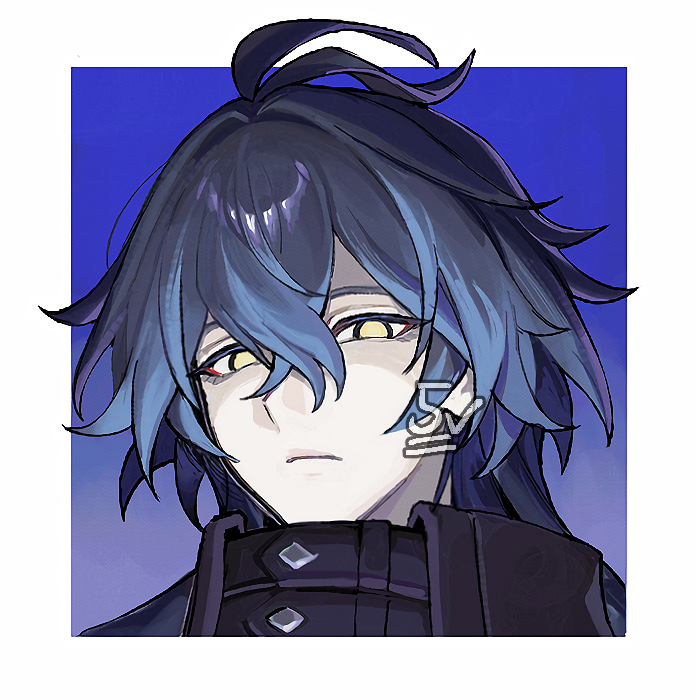

['eyeliner', 'eyeshadow', 'makeup', 'yellow eyes']
['eyeliner', 'eyeshadow', 'makeup', 'yellow eyes', 'yellow pupils']


In [55]:
from PIL import Image
current_image=Image.open(image_path)

display(current_image)
print(eyes_tags_list)
print(eyes_tags_list_after)


In [56]:
second_pass= make_merging_prompt(image_path, eyes_tags_list_after,  db)
response_final = model.generate_content(contents=second_pass)

# 4. Показать результат
print(response_final.text)

eyeliner, eyeshadow, makeup, yellow eyes with yellow pupils


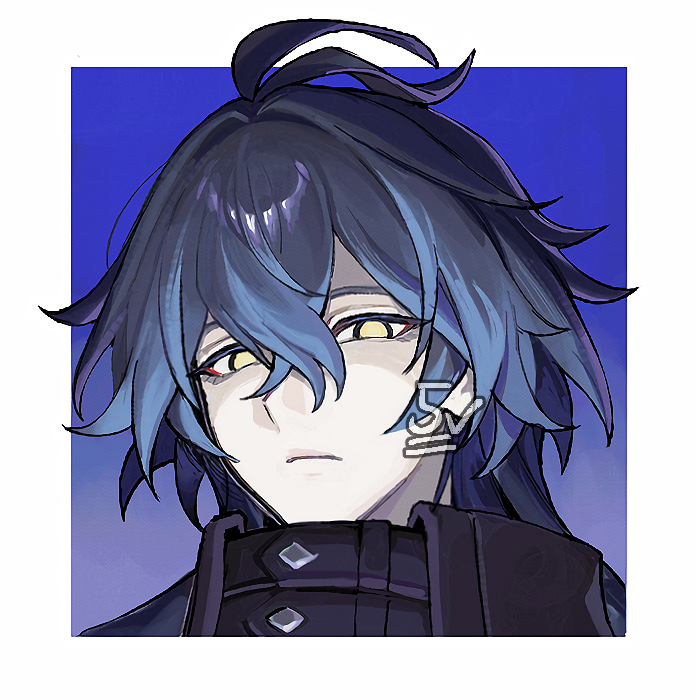

['eyeliner', 'eyeshadow', 'makeup', 'yellow eyes', 'yellow pupils']
eyeliner, eyeshadow, makeup, yellow eyes with yellow pupils


In [57]:
from PIL import Image
current_image=Image.open(image_path)

display(current_image)
print(eyes_tags_list_after)
print(response_final.text)
